In [2]:
'''
多被试的情况下该怎么做呢？
psds

snrs

power

itc

这几个变量都是可以叠加的吧，如果是做被试间，那么所有的数据都应该某人被试内平均过了，不应该有channel信息。

每个被试的这四个值分别存入不同的list当中，再来做统计 和 平均。
'''


'\n多被试的情况下该怎么做呢？\npsds\n\nsnrs\n\npower\n\nitc\n\n这几个变量都是可以叠加的吧，如果是做被试间，那么所有的数据都应该某人被试内平均过了，不应该有channel信息。\n\n每个被试的这四个值分别存入不同的list当中，再来做统计 和 平均。\n'

In [3]:
import  mne
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np

In [4]:
data_path = 'E:\实验\阅读困难\数据处理\pre1nanshi\data\\6epoch_equalization_oddball\\'
#被试2的数据不完整
sub_ids = [
            'pre1001','pre1003','pre1004','pre1005','pre1006'
          ]
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise


In [5]:
list_psds_odd_std = list()

list_snrs_odd_std_mean = list()

list_power_odd_std = list()

list_itc_odd_std = list()


for sub_id in sub_ids:

    '''
    思路:直接合并std和odd的数据
    这里有个默认假设就是,可以克服 BA TA 物理差异
    实际上还应该考虑
    '''
    epochs_std_BA = mne.read_epochs(data_path+sub_id+'_std_BA-epo.fif')
    epochs_std_TA = mne.read_epochs(data_path+sub_id+'_std_TA-epo.fif')

    #写错了，名字暂时不变。epochs_std_fuyin
    epochs_std_BA = mne.concatenate_epochs([epochs_std_BA,epochs_std_TA])

    epochs_odd_TA = mne.read_epochs(data_path+sub_id+'_odd_TA-epo.fif')
    epochs_odd_BA = mne.read_epochs(data_path+sub_id+'_odd_BA-epo.fif')

    epochs_odd_TA = mne.concatenate_epochs([epochs_odd_BA,epochs_odd_TA])


    tmin = 0.
    tmax = 1.0
    fmin = 1.
    fmax = 40.
    #这个是采样率，1000Hz
    sfreq = epochs_std_BA.info['sfreq']

    #PSD shape (n_epochs, n_channels, n_freqs).  (116, 62, 40)
    '''
    问题：为什么只有32个频率？这个是由什么决定的呢？
    肯定是某个参数没有搞明白，FFT的理论问题
    '''
    '''
    这里的PSDS放的是扰动能量值。
    那么我应该理解为是1 2 3 这些整数的位置？

    为什么freqs一定是8个呢？？
    这个和psd应该不一样吧。 psd中的是40个啊
    '''
    psds, freqs_std = mne.time_frequency.psd_welch(
        epochs_std_BA,
        #时间戳的个数？
        #这里相当于是用了全部作为窗口？那就只有一次了。。应该配合汉明窗，缩减单个窗口的长度
        n_fft=int(sfreq * (tmax - tmin)),
        #被试间分析，被试内trial需要先平均了。
        average='mean',
        n_overlap=0, n_per_seg=None,
        tmin=tmin, tmax=tmax,
        fmin=fmin, fmax=fmax,
        # 这里不是 hamming窗
        window='boxcar',
        verbose=False)
    psds_odd,freqs_odd = mne.time_frequency.psd_welch(
        epochs_odd_TA,
        n_fft=int(sfreq * (tmax - tmin)),
        average='mean',

        tmin=tmin, tmax=tmax,
        fmin=fmin, fmax=fmax,
        window='boxcar',
        verbose=False)
    # psds是平均过的，这里应该也是
    freq_range = range(np.where(np.floor(freqs_std) == 1.)[0][0],
                   np.where(np.ceil(freqs_std) == fmax - 1)[0][0])

    snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                        noise_skip_neighbor_freqs=0)
    snrs_odd = snr_spectrum(psds_odd, noise_n_neighbor_freqs=3,
                        noise_skip_neighbor_freqs=0)
    # 在试次 和 channel维度上都进行了平均处理，而且通过【】取出来感兴趣的部分。range(0, 38)
    snr_mean = snrs_odd.mean(axis=(0, 1))[freq_range] - snrs.mean(axis=(0, 1))[freq_range]
    snr_std = snrs_odd.std(axis=(0, 1))[freq_range] - snrs.std(axis=(0, 1))[freq_range]
    list_snrs_odd_std_mean.append(snr_mean)

    # 你想让他们进行相减 但是这里的power已经被平均过了
    # 如果是每个被试的epochs单独拿出来算power，然后呢？
    # 还是平均power的好，不然就是以试次为单位了，所以才会没有ITC。
    # 应该是先计算出两个条件的平均power，然后再来相减。最后才是组间统计。
    '''
    作图需要改一下，聚焦感兴趣的区间。
    '''
    freqs = np.logspace(*np.log10([1, 50]), num=8)
    freqs = np.linspace(1,40)
    n_cycles = freqs / 2.
    power,itc = tfr_morlet(epochs_std_BA, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1, average=True)
    power_odd, itc_odd = tfr_morlet(epochs_odd_TA, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1, average=True)
    nd_power = power.data
    nd_power_odd = power_odd.data
# 直接相减有问题的。
# 如果不相减，那就是做统计T了，感觉应该也行。
    nd_power_m = nd_power_odd - nd_power
    list_power_odd_std.append(nd_power_m)


    nd_itc = itc.data
    nd_itc_odd = itc_odd.data

# 直接相减有问题的。 m代表 minus
    nd_itc_m = nd_itc_odd - nd_itc
    list_itc_odd_std.append(nd_itc_m)


Reading E:\实验\阅读困难\数据处理\pre1nanshi\data\6epoch_equalization_oddball\pre1001_std_BA-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Reading E:\实验\阅读困难\数据处理\pre1nanshi\data\6epoch_equalization_oddball\pre1001_std_TA-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
124 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Reading E:\实验\阅读困难\数据处理\pre1nanshi\data\6epoch_equalization_oddball\pre1001_odd_TA-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices avai

In [6]:
print(freqs_std)
print(freqs)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40.]
[ 1.          1.79591837  2.59183673  3.3877551   4.18367347  4.97959184
  5.7755102   6.57142857  7.36734694  8.16326531  8.95918367  9.75510204
 10.55102041 11.34693878 12.14285714 12.93877551 13.73469388 14.53061224
 15.32653061 16.12244898 16.91836735 17.71428571 18.51020408 19.30612245
 20.10204082 20.89795918 21.69387755 22.48979592 23.28571429 24.08163265
 24.87755102 25.67346939 26.46938776 27.26530612 28.06122449 28.85714286
 29.65306122 30.44897959 31.24489796 32.04081633 32.83673469 33.63265306
 34.42857143 35.2244898  36.02040816 36.81632653 37.6122449  38.40816327
 39.20408163 40.        ]


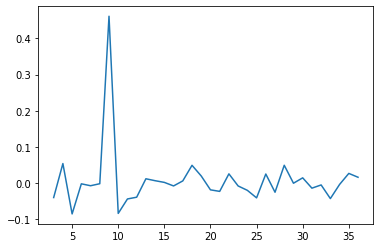

In [7]:
'''
进行组平均
这里肯定是不能直接作图的啊

snrs的
'''
import statistics
snr_mean_group = sum(list_snrs_odd_std_mean)/len(list_snrs_odd_std_mean)
plt.plot(snr_mean_group)

In [7]:
%matplotlib qt
for i in range(5):
    plt.plot(list_snrs_odd_std_mean[i])

Applying baseline correction (mode: mean)


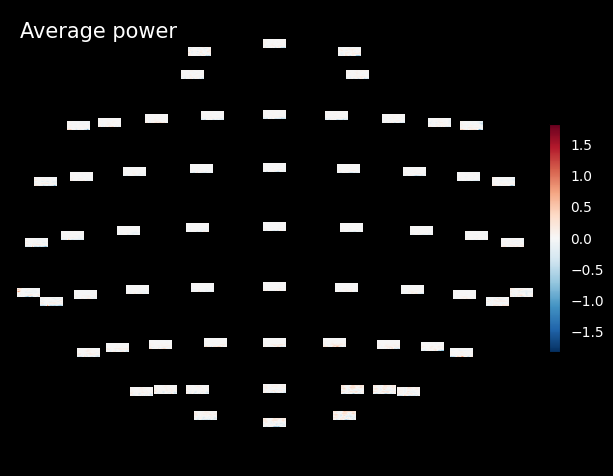

In [28]:
%matplotlib qt
power_mean_group = sum(list_power_odd_std)/len(list_power_odd_std)
power_mean = power.copy()
power_mean.data = power_mean_group
power_mean.plot_topo(baseline=(-0.2, 0), mode='mean', title='Average power')

Applying baseline correction (mode: mean)


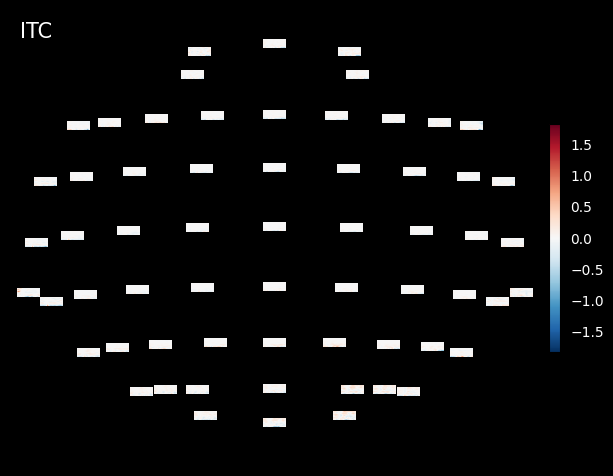

In [26]:
itc_mean_group = sum(list_power_odd_std)/len(list_power_odd_std)
itc.data = power_mean_group
itc.plot_topo(baseline=(-0.2, 0), mode='mean', title='ITC')